# Back-and-forth (JAX) additional experiments
Two extra scenarios—one smooth and one discontinuous—run through the JAX implementation in `methods/back_and_forth`.

In [1]:

import sys
from pathlib import Path
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

repo_root = str(Path.cwd().parents[1])
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

from methods.back_and_forth.method import backnforth_sqeuclidean_nd
from methods.back_and_forth.pushforward import adaptive_pushforward_nd

sns.set_theme(style='whitegrid', context='paper')
plt.rcParams.update({'figure.dpi': 120})


In [2]:

def run_case(mu_np, nu_np, coords, stepsize, maxiter=60, title='case'):
    mu = jnp.asarray(mu_np, dtype=jnp.float64)
    nu = jnp.asarray(nu_np, dtype=jnp.float64)
    result = backnforth_sqeuclidean_nd(
        mu, nu, coords,
        stepsize=stepsize,
        maxiterations=maxiter,
        tolerance=1e-12,
        pushforward_fn=adaptive_pushforward_nd,
        progressbar=False)
    (iterations, phi, psi, rho_nu, rho_mu, errors, dual_values, sigma_history) = result
    it = int(iterations)
    return {
        'iterations': it,
        'rho_mu': np.array(rho_mu),
        'rho_nu': np.array(rho_nu),
        'errors': np.array(errors[:it]),
        'dual': np.array(dual_values[:it]),
        'sigma': np.array(sigma_history[:it]),
        'title': title
    }


def plot_density_pair(mu_np, nu_np, title):
    vmin = min(mu_np.min(), nu_np.min())
    vmax = max(mu_np.max(), nu_np.max())
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    im = ax[0].imshow(mu_np, origin='lower', extent=(0,1,0,1), cmap='magma', vmin=vmin, vmax=vmax)
    ax[0].set_title(f'{title}: $mu$')
    ax[1].imshow(nu_np, origin='lower', extent=(0,1,0,1), cmap='magma', vmin=vmin, vmax=vmax)
    ax[1].set_title(f'{title}: $nu$')
    for a in ax:
        a.set_xticks([]); a.set_yticks([])
    fig.subplots_adjust(right=0.88, wspace=0.05)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()


def plot_pushforward(mu_np, nu_np, rho_mu, rho_nu, title):
    vmin = min(mu_np.min(), nu_np.min(), rho_mu.min(), rho_nu.min())
    vmax = max(mu_np.max(), nu_np.max(), rho_mu.max(), rho_nu.max())
    fig, ax = plt.subplots(2, 2, figsize=(10, 8))
    entries = [
        (ax[0,0], mu_np, r'$\mu$ source'),
        (ax[0,1], rho_nu, r'$S_{\varphi}\#\nu$'),
        (ax[1,0], nu_np, r'$\nu$ target'),
        (ax[1,1], rho_mu, r'$T_{\psi}\#\mu$'),
    ]
    for axi, data, label in entries:
        im = axi.imshow(data, origin='lower', extent=(0,1,0,1), cmap='viridis', vmin=vmin, vmax=vmax)
        axi.set_title(label)
        axi.set_xticks([]); axi.set_yticks([])
    fig.subplots_adjust(right=0.88)
    cax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cax)
    fig.suptitle(title)
    plt.show()


def plot_history(stats, title):
    fig, axes = plt.subplots(1, 3, figsize=(13, 3.2))
    dual = stats['dual']; sigma = stats['sigma']; err = np.clip(stats['errors'], 1e-12, None)
    axes[0].plot(dual); axes[0].set_title('dual value'); axes[0].set_xlabel('step'); axes[0].grid(True)
    axes[1].plot(sigma); axes[1].set_title('stepsize'); axes[1].set_xlabel('step'); axes[1].grid(True)
    axes[2].plot(err); axes[2].set_yscale('log'); axes[2].set_title('error'); axes[2].set_xlabel('step'); axes[2].grid(True)
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


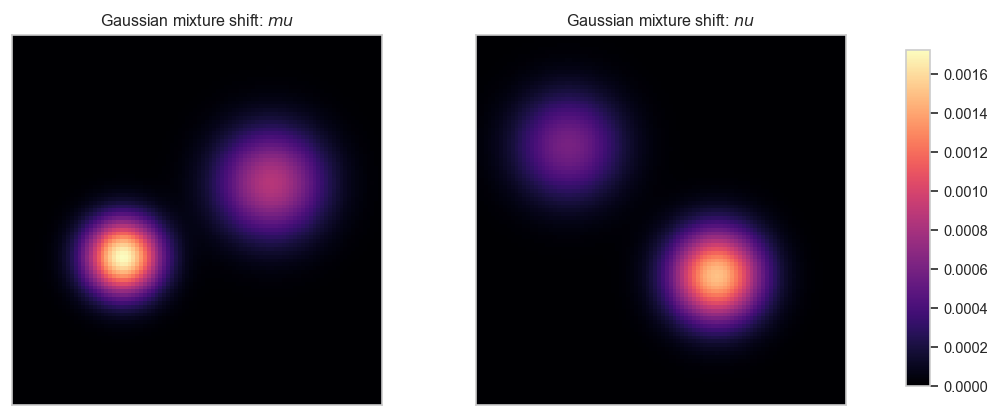

/var/folders/zt/h5ncncv1043cdpswcj8nysgm0000gn/T/ipykernel_84153/2382436857.py:2: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  mu = jnp.asarray(mu_np, dtype=jnp.float64)
/var/folders/zt/h5ncncv1043cdpswcj8nysgm0000gn/T/ipykernel_84153/2382436857.py:3: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  nu = jnp.asarray(nu_np, dtype=jnp.float64)


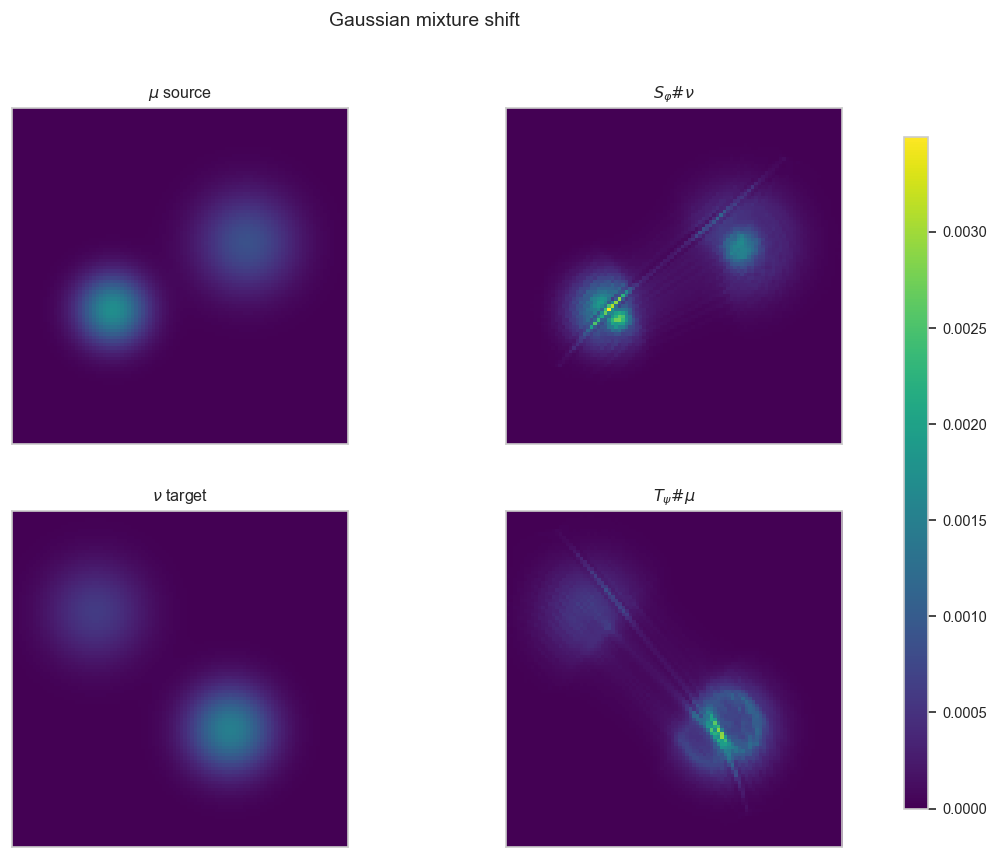

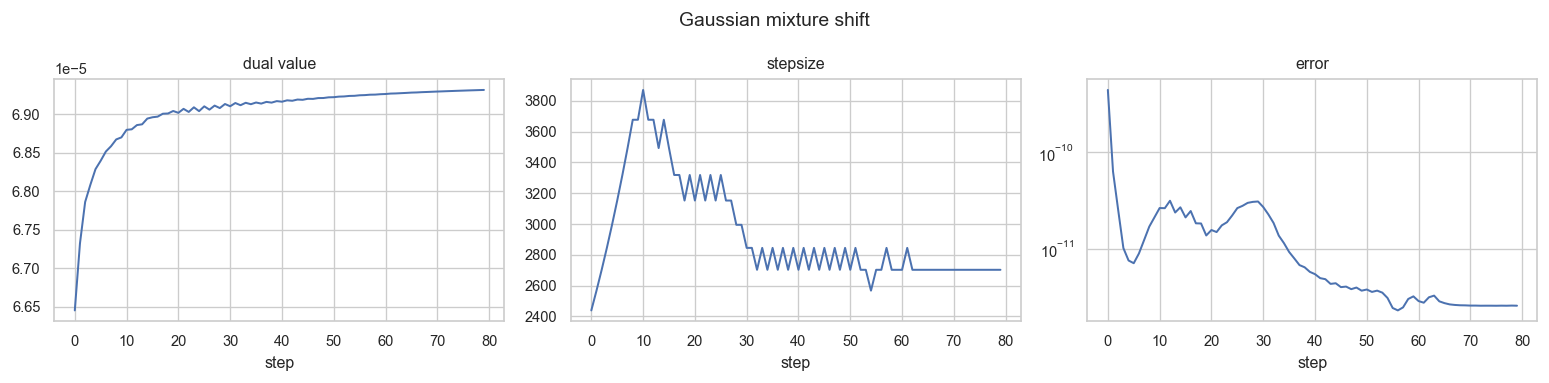

In [3]:
# Case 1: Gaussian mixture shift (smooth)
n1 = n2 = 96
xs = np.linspace(0.5/n1, 1-0.5/n1, n1)
ys = np.linspace(0.5/n2, 1-0.5/n2, n2)
x, y = np.meshgrid(xs, ys)
mu_np = np.exp(-((x-0.3)**2 + (y-0.4)**2)/0.01) + 0.5*np.exp(-((x-0.7)**2 + (y-0.6)**2)/0.02)
nu_np = np.exp(-((x-0.65)**2 + (y-0.35)**2)/0.015) + 0.4*np.exp(-((x-0.25)**2 + (y-0.7)**2)/0.02)
mu_np = np.clip(mu_np, 0, None); nu_np = np.clip(nu_np, 0, None)
mu_np /= mu_np.sum(); nu_np /= nu_np.sum()
coords = [jnp.asarray(xs), jnp.asarray(ys)]
plot_density_pair(mu_np, nu_np, 'Gaussian mixture shift')
case1 = run_case(mu_np, nu_np, coords,
                 stepsize=4/max(mu_np.max(), nu_np.max()),
                 maxiter=80, title='Gaussian mixture shift')
plot_pushforward(mu_np, nu_np, case1['rho_mu'], case1['rho_nu'], 'Gaussian mixture shift')
plot_history(case1, 'Gaussian mixture shift')

/var/folders/zt/h5ncncv1043cdpswcj8nysgm0000gn/T/ipykernel_84153/3364615938.py:13: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  coords = [jnp.asarray(xs, dtype=jnp.float64), jnp.asarray(ys, dtype=jnp.float64)]


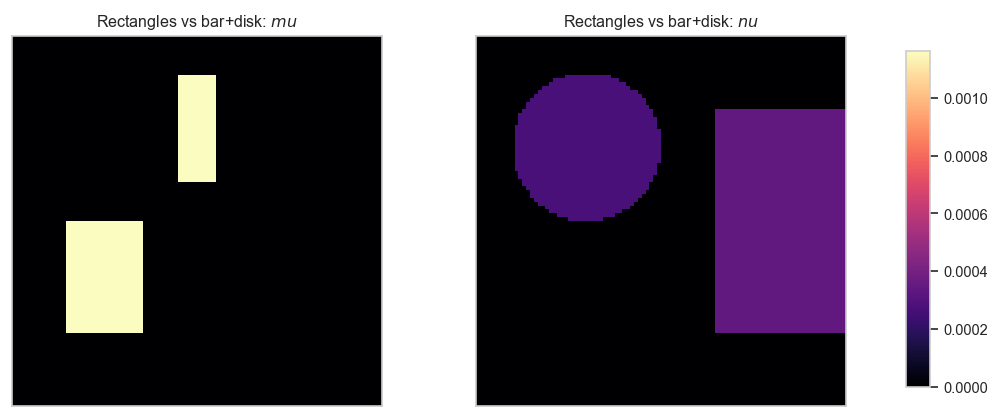

/var/folders/zt/h5ncncv1043cdpswcj8nysgm0000gn/T/ipykernel_84153/2382436857.py:2: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  mu = jnp.asarray(mu_np, dtype=jnp.float64)
/var/folders/zt/h5ncncv1043cdpswcj8nysgm0000gn/T/ipykernel_84153/2382436857.py:3: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  nu = jnp.asarray(nu_np, dtype=jnp.float64)


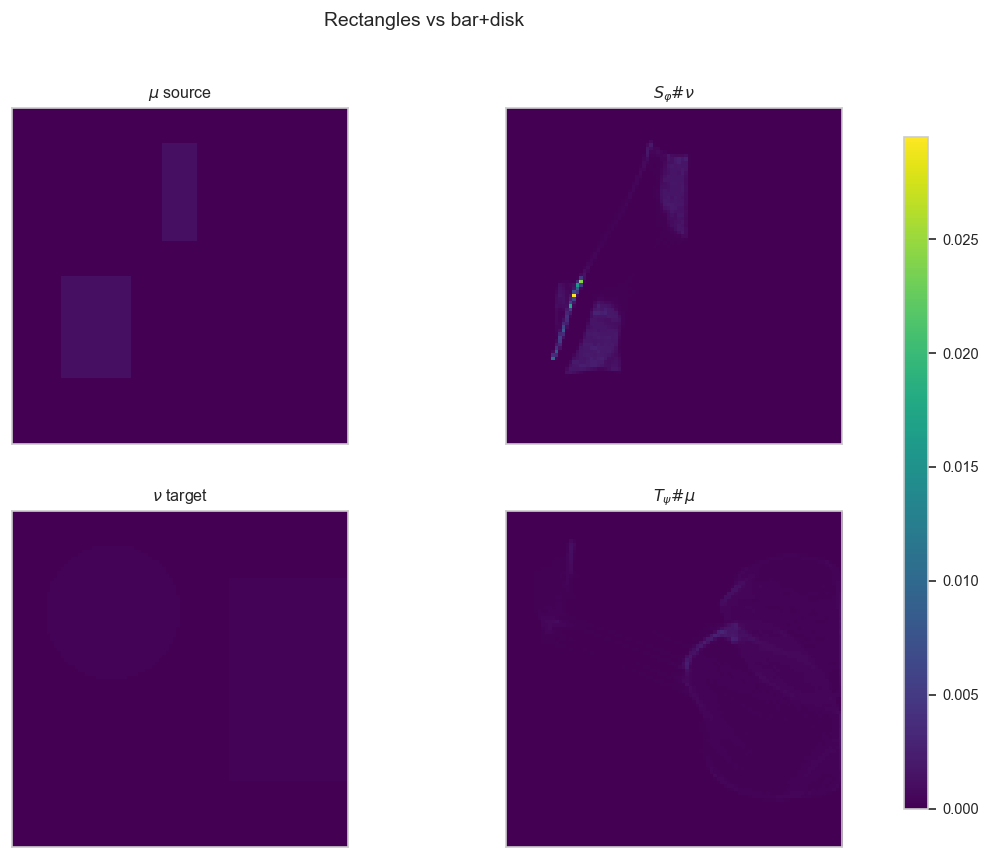

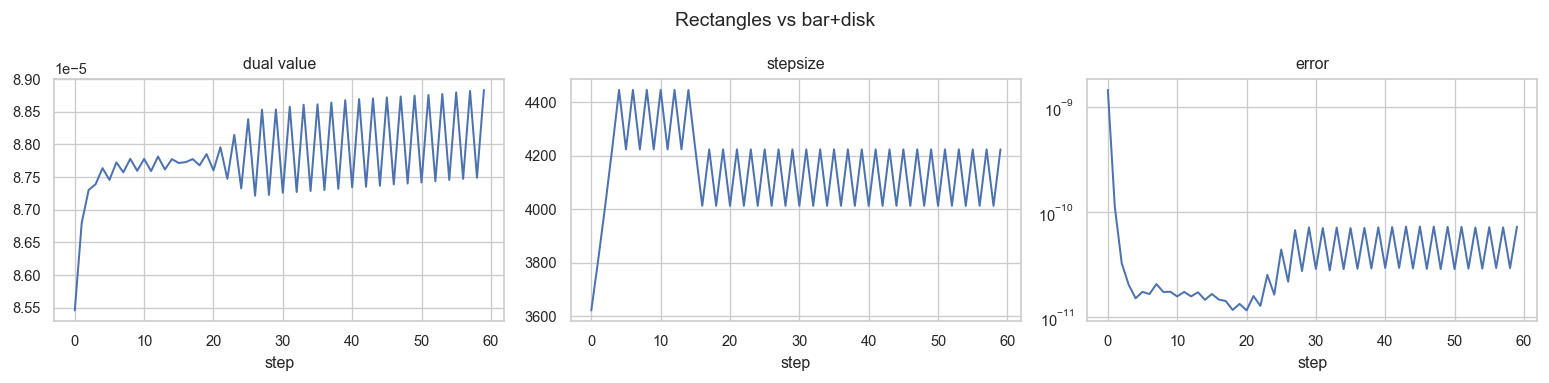

In [4]:
# Case 2: Rectangles vs bars/disks (discontinuous)
n1 = n2 = 96
xs = np.linspace(0.5/n1, 1-0.5/n1, n1)
ys = np.linspace(0.5/n2, 1-0.5/n2, n2)
x, y = np.meshgrid(xs, ys)
mu_np = np.zeros_like(x)
mu_np[(x>0.15)&(x<0.35)&(y>0.2)&(y<0.5)] = 1
mu_np[(x>0.45)&(x<0.55)&(y>0.6)&(y<0.9)] = 1
nu_np = np.zeros_like(x)
nu_np[(y>0.2)&(y<0.8)&(x>0.65)] = 1
nu_np[((x-0.3)**2 + (y-0.7)**2) < 0.04] = 0.8
mu_np /= mu_np.sum(); nu_np /= nu_np.sum()
coords = [jnp.asarray(xs, dtype=jnp.float64), jnp.asarray(ys, dtype=jnp.float64)]
plot_density_pair(mu_np, nu_np, 'Rectangles vs bar+disk')
case2 = run_case(mu_np, nu_np, coords, stepsize=4/max(mu_np.max(), nu_np.max()), maxiter=60, title='Rectangles vs bar+disk')
plot_pushforward(mu_np, nu_np, case2['rho_mu'], case2['rho_nu'], 'Rectangles vs bar+disk')
plot_history(case2, 'Rectangles vs bar+disk')